# XGBoost (eXtreme Gradient Boosting)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import pickle
import os
import scipy.stats as st
from itertools import combinations
from azure.storage.blob import BlockBlobService

In [2]:
# Use the Azure Machine Learning data collector to log various metrics
from azureml.logging import get_azureml_logger
logger = get_azureml_logger()

In [3]:
model_name = "xgboost"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
ACCOUNT_NAME = "petcgexperimentstorage"
ACCOUNT_KEY = "C+ffy45PBcicHAxWiRbW9MnFR651A8xbiVe2wkyZgolznhFf70caTZmpWIJb2spV5YFl/LQB0ARUfU+AQx6w9g=="
CONTAINER_NAME = "energy-demand-demo"
block_blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)
train = None
list_of_blobs = block_blob_service.list_blobs(CONTAINER_NAME)
for each_blob in list_of_blobs:
    if ("part-00" in each_blob.name):
        block_blob_service.get_blob_to_path(CONTAINER_NAME, blob_name=each_blob.name, file_path='./nyc_demand.csv')
        train = pd.read_csv('./nyc_demand.csv')
        break

Use randomised search to find optimal hyperparameters. This model will take about 5 minutes to train. The quality of the solution may be improved by increasing the number of iterations in the randomized search, at the expense of increased training times.

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
regr = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
param_dist = {'n_estimators': st.randint(3, 100),
                'learning_rate': st.uniform(0.05, 0.4),
                'max_depth': range(3,40),
                'min_child_weight': st.expon(0, 40),
                'colsample_bytree': st.beta(10, 1),
                'gamma': st.uniform(0, 10),
                'subsample': st.beta(10, 1),
                'reg_alpha': st.expon(0, 40)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=50,
            cv=tscv,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min


Cross validation results

In [14]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
31,18.615295,0.240003,-2546.335079,-174.028289,0.966008,1.18257,0.129876,30,9.83675,83,7.03582,0.9994,"{'n_estimators': 83, 'subsample': 0.9994003012...",1,-3547.833036,-183.789988,-2013.297979,-174.665809,-2077.874221,-163.629072,7.836145,0.038506,708.656542,8.242995
13,10.801665,0.117670,-2671.097878,-514.800158,0.983749,6.80078,0.159993,26,12.09,61,93.3801,0.96222,"{'n_estimators': 61, 'subsample': 0.9622195743...",2,-3809.155782,-589.547236,-2087.730816,-484.282530,-2116.407036,-470.570707,4.868201,0.021747,804.813612,53.149775
32,10.558661,0.147996,-2711.332827,-1102.221986,0.925699,4.07324,0.0759548,13,15.166,98,19.1142,0.775883,"{'n_estimators': 98, 'subsample': 0.7758834829...",3,-3851.170231,-1213.540827,-2161.867186,-1125.654886,-2120.961066,-967.470246,4.806083,0.030337,806.159747,101.815219
17,20.510334,0.215005,-2776.335757,-173.602191,0.938375,2.11029,0.192719,35,12.8646,83,2.64036,0.974303,"{'n_estimators': 83, 'subsample': 0.9743030002...",4,-3760.496623,-162.994689,-2224.199512,-177.708460,-2344.311137,-180.103424,8.197634,0.018237,697.632261,7.564094
41,21.129120,0.248000,-2804.659233,-463.196964,0.956142,7.44208,0.171347,23,18.2968,98,0.535519,0.954684,"{'n_estimators': 98, 'subsample': 0.9546840796...",5,-4042.725204,-470.289771,-2142.945713,-478.725740,-2228.306782,-440.575382,8.494129,0.031950,876.138170,16.362424


Inspect the pairwise distribution of cross validation scores. Darker shades of blue indicate superior performance while the red star represents the optimal solution found.

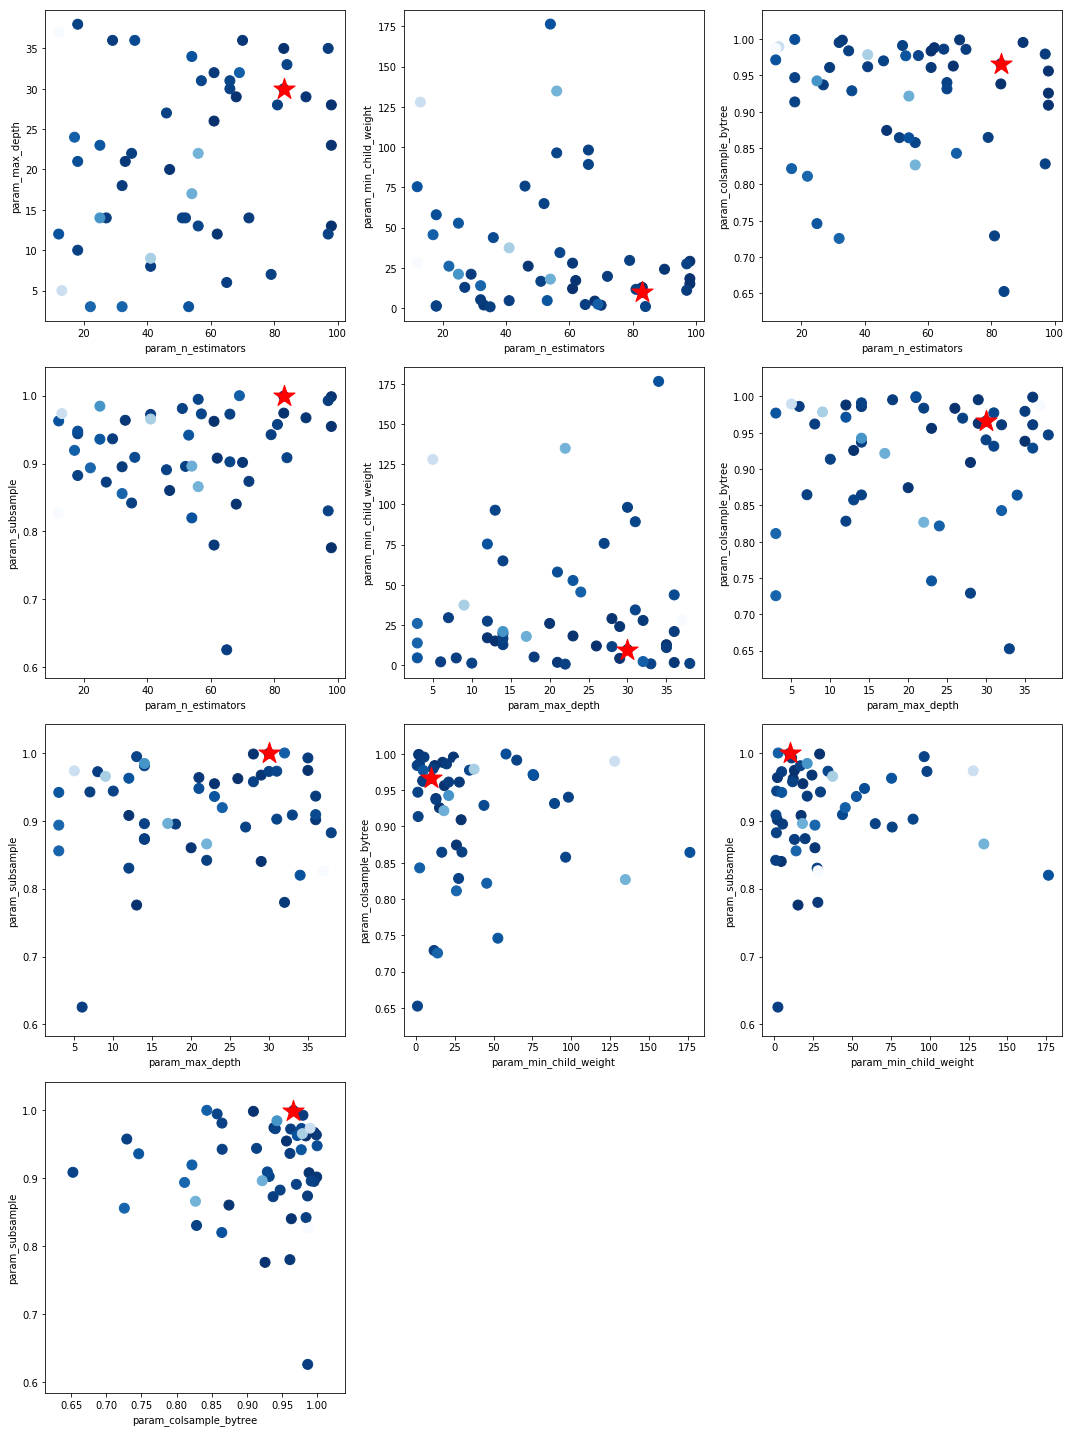

In [18]:
params = ['param_n_estimators', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'param_subsample']
gs = gridspec.GridSpec(4,3)
fig = plt.figure(figsize=(15, 20), tight_layout=True)
plt_best = cv_results.head(1)
for idx, params in enumerate(combinations(params, 2)):
    ax = fig.add_subplot(gs[idx])
    plt.scatter(cv_results[params[0]], cv_results[params[1]], c=-np.log(-cv_results['mean_test_score']), s=100, cmap="Blues")
    plt.scatter(plt_best[params[0]], plt_best[params[1]], s=500, marker="*", c="r")
    plt.xlabel(params[0])
    plt.ylabel(params[1])

Inspect feature importance

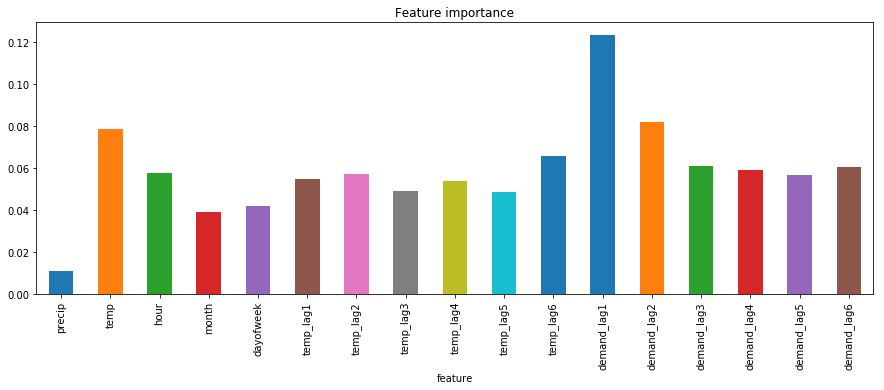

In [22]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5), logy=False, title='Feature importance', legend=False)
plt.show()

In [ ]:
model_dir = "C:/Users/nelgoh/Desktop/Resources/Petronas/energy_demand_forecast/EnergyDemandForecast/outputs/models/"
with open(os.path.join(model_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)